# Time Series, peak detection and forecasting

## Wikipedia page views

We are going to look at the number of wikipedia pageviews using the *Pageview API*: a public API developed and maintained by the Wikimedia Foundation that serves analytical data about article pageviews of Wikipedia.

Here we are going to use a GET request, but note that there exists a Python WMF Pageview client: [mwviews](https://github.com/mediawiki-utilities/python-mwviews).

### Imports

In [1]:
import numpy as np
print("Numpy version: {}".format(np.__version__))
import pandas as pd
print("Pandas version: {}".format(pd.__version__))
import requests
print("Requests version: {}".format(requests.__version__))
import peakutils
print("PeakUtils version: {}".format(peakutils.__version__))
import scipy
print("SciPy version: {}".format(scipy.__version__))
from scipy import signal
from datetime import timedelta
import fbprophet as Prophet
print("Prophet version: {}".format(Prophet.__version__))
import matplotlib
print("Matplotlib version: {}".format(matplotlib.__version__))
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')  # warning are useless :)

Numpy version: 1.14.3
Pandas version: 0.23.0
Requests version: 2.18.4
PeakUtils version: 1.1.1
SciPy version: 1.1.0
Prophet version: 0.2.1
Matplotlib version: 2.2.2


### Getting the data

![alt text](./Johnny.jpg)

Let's construct the url in order to get a pageview count timeseries of fr.wikipedia's article [Johnny_Hallyday](https://fr.wikipedia.org/wiki/Johnny_Hallyday) from January 1st 2016 to June 7h 2018 counting only the pageviews generated by human users:

In [2]:
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/fr.wikipedia/all-access/user/Johnny_Hallyday/daily/2016010100/2018060700'

In [3]:
class APIError(Exception):
    '''An API Error Exception
    '''

    def __init__(self, status):
        self.status = status

    def __str__(self):
        return "status={}".format(self.status)
    
resp = requests.get(url)
if resp.status_code != 200:
    raise APIError(resp.status_code)

Move the JSON response into a Pandas dataframe:

In [4]:
df = pd.DataFrame(data=resp.json()['items'])
df.head(2)

,access,agent,article,granularity,project,timestamp,views
0,all-access,user,Johnny_Hallyday,daily,fr.wikipedia,2016010100,4076
1,all-access,user,Johnny_Hallyday,daily,fr.wikipedia,2016010200,3405


Create a `DateTimeIndex` and remove useless columns:

In [5]:
df = df[['timestamp', 'views']]
df['date'] = pd.to_datetime(df.timestamp, format='%Y%m%d00')
df.drop('timestamp', axis=1, inplace=True)
df.set_index('date', inplace=True)
df.head(2)

,views
date,
2016-01-01,4076
2016-01-02,3405


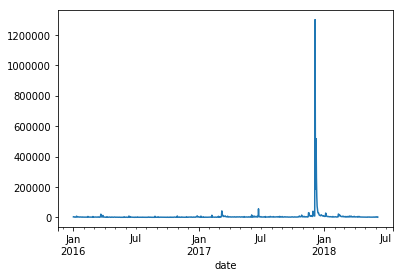

In [6]:
df.views.plot()

Well obviously something happened at the end of 2017. 

Let's Log transform the data so that when can observe something else than one giant spike.

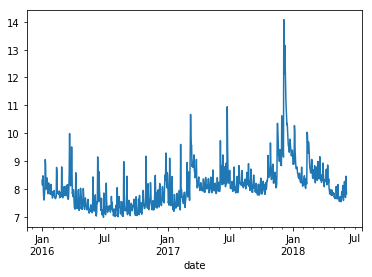

In [7]:
df['log_views'] = np.log(df.views)
df.log_views.plot()

### Peak detection

Now we run a peak detection algorithm on the views (in logarithm) with `peakutils.indexes`. We have two parameters here:
* `thres` (float between [0., 1.]) – Normalized threshold. Only the peaks with amplitude higher than the threshold will be detected.
* `min_dist` (int) – Minimum distance between each detected peak. The peak with the highest amplitude is preferred to satisfy this constraint.

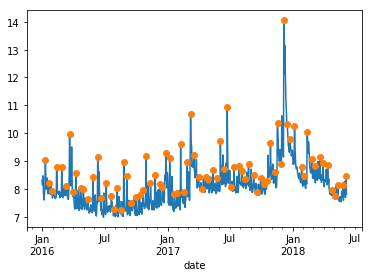

In [8]:
lpv = np.array(df.log_views)
indices = peakutils.indexes(lpv, thres=0.01, min_dist=7)
peaks = df.iloc[indices]
df.log_views.plot()
peaks.log_views.plot(style='o')

We could imagine an ultra basic way to detect a major anomaly on the page views by looking for a severe outlier among the peak distribution (using standard deviation):

In [9]:
peakval = np.array(peaks.log_views)
mean = np.mean(peakval, axis=0)
sd = np.std(peakval, axis=0)
outliers = [(i, int(np.round((x-mean)/sd))) for i, x in enumerate(peakval) if (x > mean + 2 * sd)]

for item in outliers:
    print(peaks.iloc[item[0]].name.strftime('anomaly date: %d, %b %Y'), '/ level:', item[1])
    
anomaly_dates = [peaks.iloc[outliers[idx][0]].name for idx in range(3)] 

anomaly date: 09, Mar 2017 / level: 2
anomaly date: 24, Jun 2017 / level: 2
anomaly date: 06, Dec 2017 / level: 6


In the present case the major anomaly (level 6) on the page views is the singer's death. However the actual death date is the 5th, but the news went out the day after:

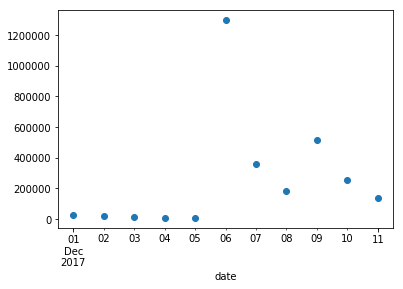

In [10]:
d = 5
anomaly_idx = 2
anomaly_date = anomaly_dates[anomaly_idx]
df[anomaly_date-timedelta(days=d):anomaly_date+timedelta(days=d)].views.plot(style='o')

The first anomaly (level 2) was when his desease was made public:

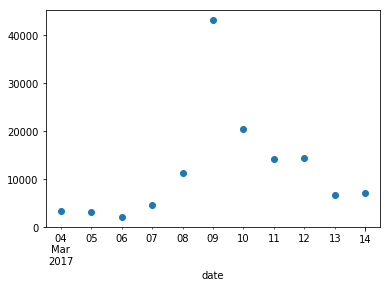

In [11]:
anomaly_idx = 0
anomaly_date = anomaly_dates[anomaly_idx]
df[anomaly_date-timedelta(days=d):anomaly_date+timedelta(days=d)].views.plot(style='o')

The second one (level 2) was his last big concert, broadcasted live on TV:

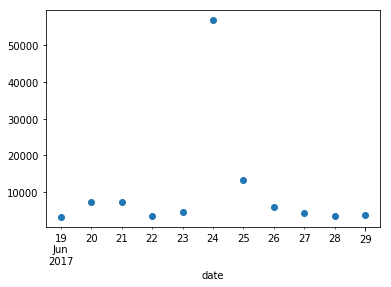

In [12]:
anomaly_idx = 1
anomaly_date = anomaly_dates[anomaly_idx]
df[anomaly_date-timedelta(days=d):anomaly_date+timedelta(days=d)].views.plot(style='o')

These three anomalies can also be spotted on the first discrete difference (absolute value):

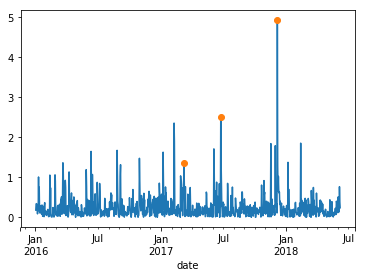

In [13]:
df.log_views.diff().abs().plot()
df.log_views.diff().abs().loc[anomaly_dates].plot(style='o')

However the main 3 anomalies do not occur exactly on the same dates: the one from the 09, Mar 2017 appears weaker, probably because the spike was a little spread-out in time and not as sharp as the others. Let us re-run `peakutils` on the difference:

date
2017-02-08    2.353349
2017-06-24    2.495817
2017-12-06    4.936149
Name: log_views, dtype: float64


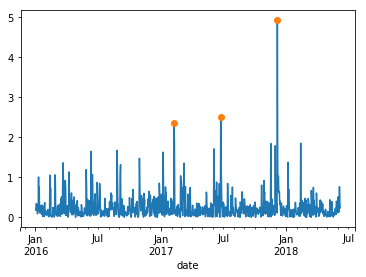

In [14]:
lpvd = np.array(df.log_views.diff().abs().dropna())
indices = peakutils.indexes(lpvd, thres=0.4, min_dist=7)
peaks = df.log_views.diff().abs().dropna().iloc[indices]
df.log_views.diff().abs().dropna().plot()
peaks.plot(style='o')
print(peaks)

Here the `thresh` parameter is set manually so as to only select the 3 main peaks. The different peak date is the 08, Feb 2017. It seems to be related to some vintage car show where he gave two rare items to collect money for a charity.

### Forecasting

We are going to use FB [Prophet](https://github.com/facebook/prophet) library to forecast the daily page views in the year to come. 

In [15]:
df['y'] = df.log_views
df['ds'] = df.index
df[['ds', 'y']].head(2)

,ds,y
date,,
2016-01-01,2016-01-01,8.312871
2016-01-02,2016-01-02,8.133000


In [16]:
model = Prophet.Prophet(daily_seasonality=False)
model.fit(df);

In [17]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

Text(0,0.5,'Page views Log()')

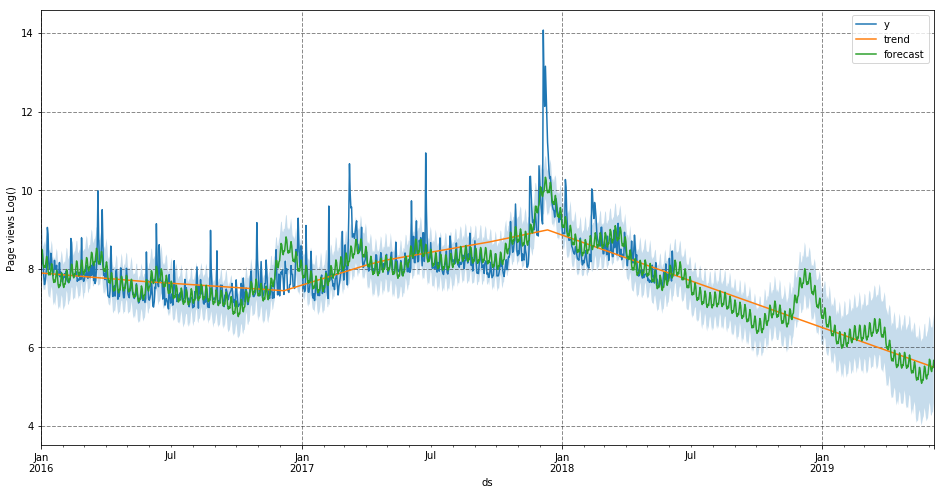

In [18]:
results = forecast.set_index('ds').join(df)
results.y.plot(figsize=(16, 8))
results.trend.plot(label='trend')
results.yhat.plot(label='forecast')
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
ax.fill_between(results.index, results['yhat_lower'], results['yhat_upper'], alpha=.25)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.ylabel("Page views Log()")

We can observe some problems with this forecast: 
* the model replicates the major anomaly of december 2017 every other december
* small oscillations in the page views are very regular in terms of frequency and amplitude (week-end peak)

Global trend looks good.

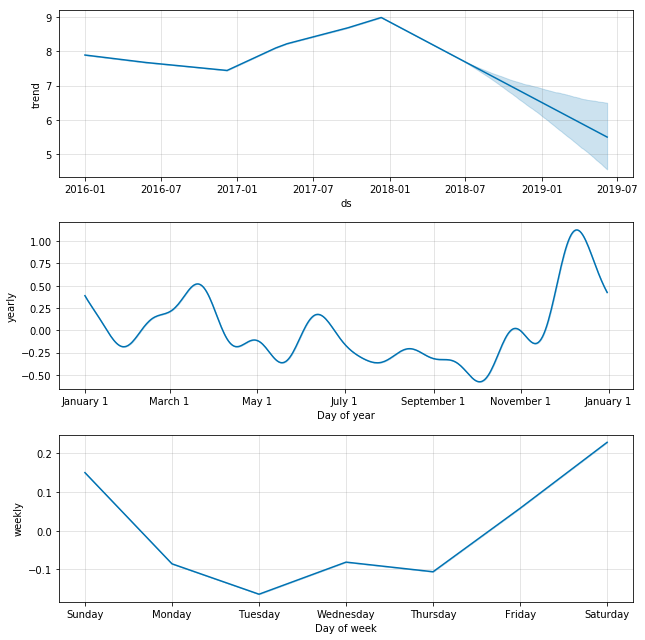

In [19]:
model.plot_components(forecast);